# Thermal Image dataset for object classification

This notebook is a image classification task for the FLIR and Seek Thermal image data sets. The goal of this notebook is to classify images captured using technology from each company.

#### Seek Thermal
Seek Thermal is a company that develops thermal imaging devices and solutions for various applications, including personal, professional, and industrial use. They offer a range of handheld thermal cameras, smartphone attachments, and modules that can be integrated into other devices. Their products are known for being relatively affordable and accessible. Seek Thermal cameras are used for home inspection, firefighting, law enforcement, wildlife observation, and other activities where thermal imaging can provide valuable insights.

#### FLIR (Forward-Looking Infrared)

FLIR Systems is a well-known and established company in the field of thermal imaging, infrared cameras, and related technologies. They offer a wide range of products for various industries. FLIR's product lineup includes handheld thermal cameras, airborne and ground-based systems, scientific cameras, security systems, and more. They are known for their high-quality and high-performance thermal imaging solutions. FLIR's thermal imaging technology is used in sectors such as defense, industrial inspection, research and development, public safety, automotive, and marine applications. Their devices are often used for detecting heat signatures, conducting inspections, and enhancing situational awareness in challenging environments.

#### Dataset

The data set consists of 6414 images from Seek Thermal, and 1014 images from FLIR. Additional information regarding the data set can be found at the link. The data set may also be downloaded from the site:

https://data.mendeley.com/datasets/btmrycjpbj/1

# Code

First, important required packages.

In [6]:
import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
from transformers import ViTForImageClassification, ViTFeatureExtractor
from pathlib import Path
import os
from google.colab import drive
import zipfile
import shutil
import matplotlib.pyplot as plt
import random
from PIL import Image
from collections import Counter

The data set can be downloaded as a zip file. We can extract the data set to the desired path. Please note that this notebook was created in a Google Colab environment with Google Drive. It is recommended to run this notebook in a Google Colab environment for use with a GPU.

In [7]:
# Mount your Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
zip_file_path = '/content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification.zip' #Specify the path of the zip file.
extract_path = '/content/drive/My Drive/FLIR_Thermal_Image_Dataset/'  # Specify the path where you want to extract the files

First, view the contents of the zip file before and after unzipping the file.

In [9]:
# Viewing the contents before extraction
print("Contents of the directory before extraction:")
extracted_files_before = os.listdir(extract_path)
print(extracted_files_before)

Contents of the directory before extraction:
['.ipynb_checkpoints', 'Thermal Image dataset for object classification.zip']


In [10]:
# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [11]:
# Viewing the contents after extraction
print("Contents of the directory after extraction:")
extracted_files_after = os.listdir(extract_path)
print(extracted_files_after)


Contents of the directory after extraction:
['.ipynb_checkpoints', 'Thermal Image dataset for object classification.zip', 'Thermal Image dataset for object classification']


Notice a folder was extracted ‘Thermal Image dataset for object classification.’ We can explore the contents of the extracted folder.

In [12]:
# If the folder was created correctly, you can now explore it
main_path_dir = os.path.join(extract_path, 'Thermal Image dataset for object classification')

unique_directories = set()  # Initialize an empty set to store unique directories

for root, dirs, files in os.walk(main_path_dir):
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        unique_directories.add(dir_path)

print("Unique directories:")
for directory in unique_directories:
    print(directory)

Unique directories:
/content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/FLIR
/content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/FLIR/Test/cat
/content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/FLIR/Test
/content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/SeekThermal/Train
/content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/FLIR/Test/car
/content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/SeekThermal
/content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/FLIR/Train/cat
/content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/FLIR/Train/man
/content/drive/My Dri

The data set contains subdirectories for both the FLIR and Seek Thermal images. There are training and test sets for each set of images. Also, there are subdirectories for each desired label (‘car’, ‘man’ and ‘cat’). We can make the directories all lower case for consistincy.

In [13]:
# Path to the Seek Thermal dataset after extraction
seek_thermal_path = '/content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/SeekThermal'

def rename_directories(root_dir):
    """
    Recursively renames all directories in the specified root directory to lowercase.

    Parameters:
    root_dir (str): The root directory where directories need to be renamed.
    """
    for root, dirs, _ in os.walk(root_dir, topdown=False):
        for dir_name in dirs:
            old_dir_path = os.path.join(root, dir_name)   # Current directory path
            new_dir_name = dir_name.lower()               # Convert directory name to lowercase
            new_dir_path = os.path.join(root, new_dir_name)  # New directory path

            # Rename the directory if the new name is different
            if new_dir_name != dir_name:
                os.rename(old_dir_path, new_dir_path)
                print(f"Renamed directory: {old_dir_path} -> {new_dir_path}")

# Rename directories to start with lowercase letters
rename_directories(seek_thermal_path)

# Optional: Print the updated directory structure to verify the renaming
unique_directories = set()

for root, dirs, files in os.walk(seek_thermal_path):
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        unique_directories.add(dir_path)

print("Unique directories after renaming:")
for directory in unique_directories:
    print(directory)


Renamed directory: /content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/SeekThermal/Train/Man -> /content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/SeekThermal/Train/man
Renamed directory: /content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/SeekThermal/Train/Car -> /content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/SeekThermal/Train/car
Renamed directory: /content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/SeekThermal/Train/Cat -> /content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/SeekThermal/Train/cat
Renamed directory: /content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/SeekThermal/Train -> /content/driv

Now let's reprint the directories to make sure that the path names were updated.

In [14]:
unique_directories = set()  # Initialize an empty set to store unique directories

for root, dirs, files in os.walk(main_path_dir):
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        unique_directories.add(dir_path)

print("Unique directories:")
for directory in unique_directories:
    print(directory)

Unique directories:
/content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/SeekThermal/train/car
/content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/FLIR
/content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/FLIR/Test/cat
/content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/SeekThermal/train
/content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/FLIR/Test
/content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/SeekThermal/train/man
/content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/SeekThermal/train/cat
/content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/SeekThermal

Next, create a new path to combine the data sets. We can also view sample images from each data set.

In [15]:
# Paths for Seek Thermal and FLIR datasets after extraction
seek_thermal_train_path = '/content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/SeekThermal/train'
flir_train_path = '/content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/FLIR/Train'

# Define the target directory for the combined dataset
combined_train_path = '/content/drive/My Drive/FLIR_Thermal_Image_Dataset/Thermal Image dataset for object classification/Dataset/Combined/train'

# Create the target directory if it doesn't exist
os.makedirs(combined_train_path, exist_ok=True)

In [16]:
def show_sample_images(data_path, num_images=5, title_fontsize=8):
    classes = os.listdir(data_path)
    print(f"Classes: {classes}")

    for cls in classes:
        cls_path = os.path.join(data_path, cls)
        images = os.listdir(cls_path)
        sample_images = random.sample(images, num_images)

        print(f"Showing {num_images} sample images from class '{cls}':")
        plt.figure(figsize=(15, 15))
        for i, img_name in enumerate(sample_images):
            img_path = os.path.join(cls_path, img_name)
            img = Image.open(img_path)
            plt.subplot(1, num_images, i+1)
            plt.imshow(img)
            plt.title(f"{cls} - {img_name}", fontsize=title_fontsize)  # Set title font size
            plt.axis('off')
        plt.show()

Seek Thermal Dataset Samples:
Classes: ['man', 'car', 'cat']
Showing 5 sample images from class 'man':


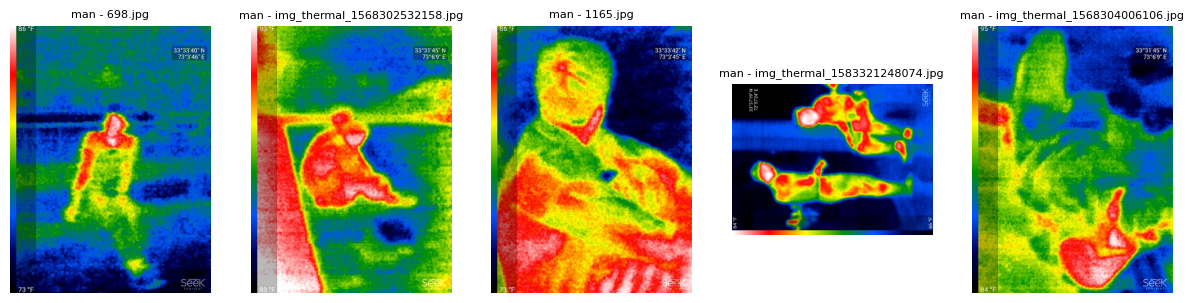

Showing 5 sample images from class 'car':


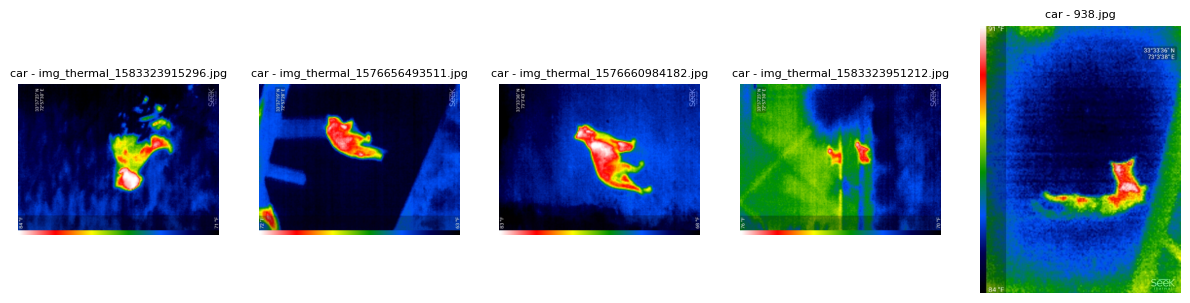

Showing 5 sample images from class 'cat':


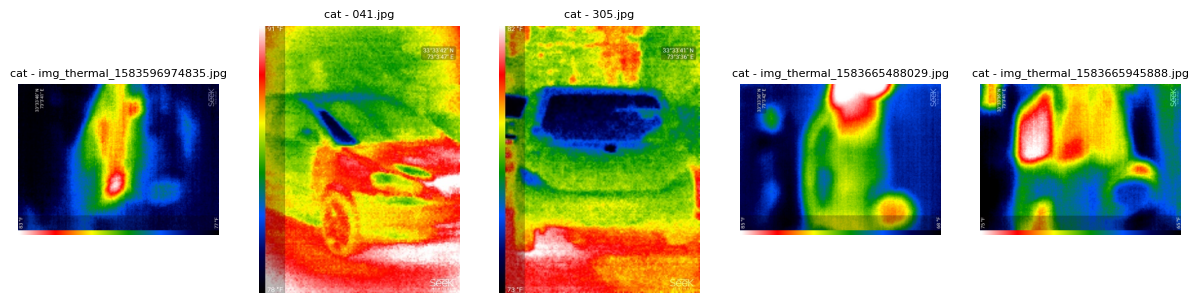

In [17]:
# Show sample images from Seek Thermal dataset
print("Seek Thermal Dataset Samples:")
show_sample_images(seek_thermal_train_path)



FLIR Dataset Samples:
Classes: ['car', 'cat', 'man']
Showing 5 sample images from class 'car':


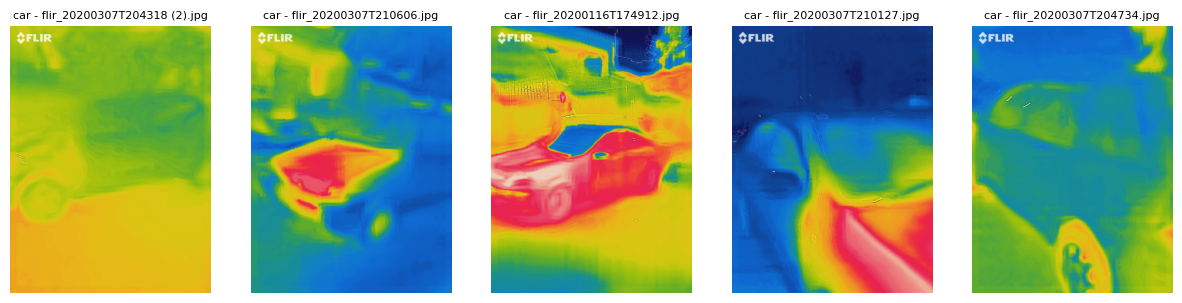

Showing 5 sample images from class 'cat':


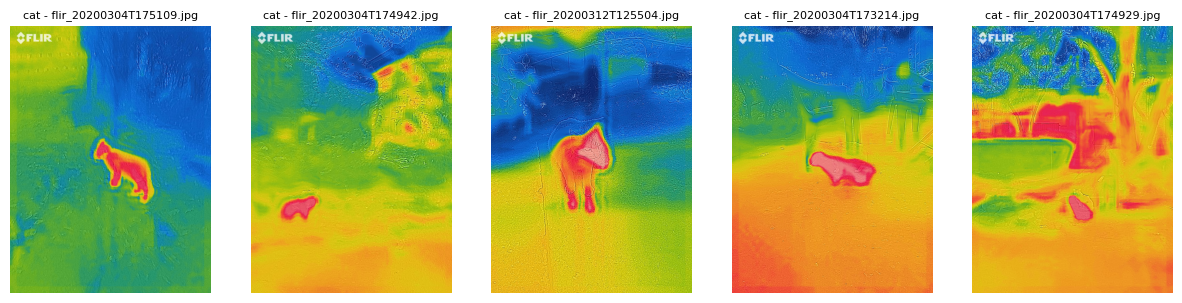

Showing 5 sample images from class 'man':


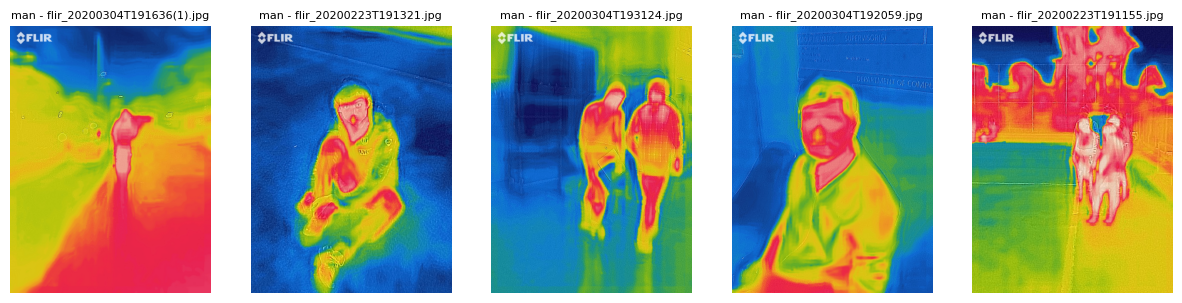

In [18]:
# Show sample images from FLIR dataset
print("FLIR Dataset Samples:")
show_sample_images(flir_train_path)

It is also good practice to check the distribution of the desired labels. It is important to ensure that the data set is not imbalanced, which could cause the model to simply predict the predominant category if there is an extreme imbalance.

In [19]:
def label_distribution(data_path):
    classes = os.listdir(data_path)
    label_counts = {}

    # Calculate the total number of images
    total_images = sum([len(os.listdir(os.path.join(data_path, cls))) for cls in classes])

    for cls in classes:
        cls_path = os.path.join(data_path, cls)
        count = len(os.listdir(cls_path))
        label_counts[cls] = {'count': count, 'percentage': (count / total_images) * 100}

    return label_counts




In [20]:
# Check label distribution in Seek Thermal dataset
seek_label_distribution = label_distribution(seek_thermal_train_path)
print("Seek Thermal Label Distribution:", seek_label_distribution)

# Check label distribution in FLIR dataset
flir_label_distribution = label_distribution(flir_train_path)
print("FLIR Label Distribution:", flir_label_distribution)


Seek Thermal Label Distribution: {'man': {'count': 1782, 'percentage': 37.658495350803044}, 'car': {'count': 1168, 'percentage': 24.683009298393912}, 'cat': {'count': 1782, 'percentage': 37.658495350803044}}
FLIR Label Distribution: {'car': {'count': 250, 'percentage': 30.826140567200987}, 'cat': {'count': 272, 'percentage': 33.53884093711467}, 'man': {'count': 289, 'percentage': 35.63501849568434}}


In [21]:
def plot_label_distribution(label_distribution, dataset_name):
    labels = list(label_distribution.keys())
    counts = [label_distribution[label]['count'] for label in labels]
    percentages = [label_distribution[label]['percentage'] for label in labels]

    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.bar(labels, counts, alpha=0.7)
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.title(f"Label Distribution (Counts) in {dataset_name}")

    plt.subplot(1, 2, 2)
    plt.bar(labels, percentages, alpha=0.7)
    plt.xlabel("Classes")
    plt.ylabel("Percentage of Images")
    plt.title(f"Label Distribution (Percentage) in {dataset_name}")

    plt.show()


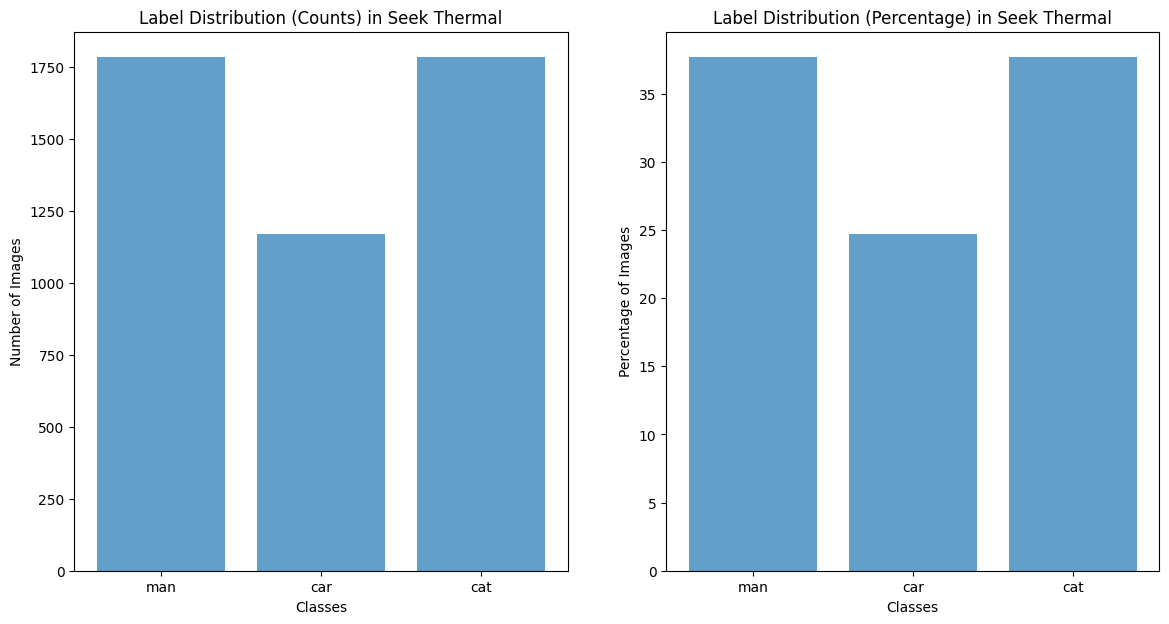

In [22]:
# Visualize Seek Thermal dataset distribution
plot_label_distribution(seek_label_distribution, "Seek Thermal")

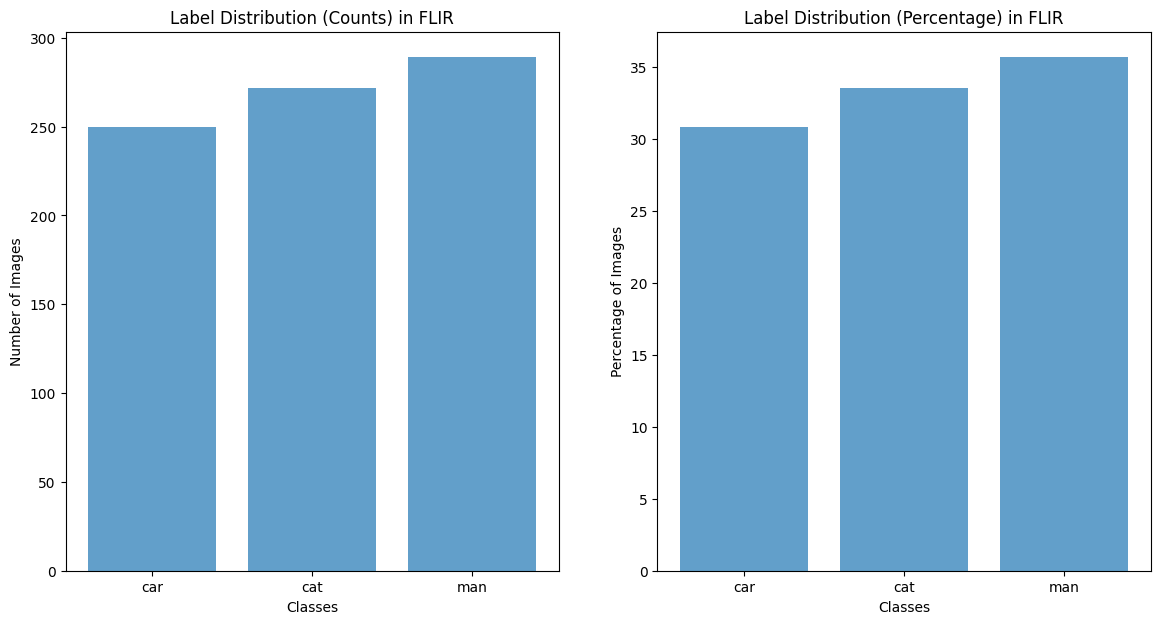

In [23]:
# Visualize FLIR dataset distribution
plot_label_distribution(flir_label_distribution, "FLIR")

The data set appear to have a good balance of all of the desire labels. We can now merge the directories to create a single data set. A function ‘count_files_in_directory’ is also created to ensure that the data sets were combined correctly. We get a count of both directories and ensure that the combined data set match the total expected number of images.

In [24]:
# Function to merge the directories
def merge_directories(source_dir, target_dir):
    for label in os.listdir(source_dir):
        source_label_dir = os.path.join(source_dir, label)
        target_label_dir = os.path.join(target_dir, label)

        # Create the target label directory if it doesn't exist
        os.makedirs(target_label_dir, exist_ok=True)

        # Copy the images to the target directory
        for file_name in os.listdir(source_label_dir):
            source_file = os.path.join(source_label_dir, file_name)
            target_file = os.path.join(target_label_dir, file_name)
            shutil.copy(source_file, target_file)

In [25]:
# Merge Seek Thermal and FLIR datasets into the combined directory
merge_directories(seek_thermal_train_path, combined_train_path)
merge_directories(flir_train_path, combined_train_path)

In [26]:
def count_files_in_directory(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
    return total_files

# Count files in Seek Thermal and FLIR directories
seek_file_count = count_files_in_directory(seek_thermal_train_path)
flir_file_count = count_files_in_directory(flir_train_path)

# Count files in the combined directory
combined_file_count = count_files_in_directory(combined_train_path)

print(f"Seek Thermal file count: {seek_file_count}")
print(f"FLIR file count: {flir_file_count}")
print(f"Combined directory file count: {combined_file_count}")

# Check if the combined directory has the correct number of files
if combined_file_count == seek_file_count + flir_file_count:
    print("Merging was successful: file counts match.")
else:
    print("Merging might have issues: file counts do not match.")


Seek Thermal file count: 4732
FLIR file count: 811
Combined directory file count: 5543
Merging was successful: file counts match.


The data is now ready for modeling. We will use a image classification model from Hugging Face. Hugging Face is a great tool for open-source transformer models. The model we will use is a popular model for image classification: 'google/vit-base-patch16-224'. Additional information regarding the model can be found at the link below:

https://huggingface.co/google/vit-base-patch16-224


To begin, we will use a feature extractor to get the expected output of the model. We can use this to ensure that our images are preprocessed appropriately for the model. We can then use these features to transform the images as needed.

In [27]:
# Initialize the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [28]:
# Define transforms using the feature extractor's specifications
transform = transforms.Compose([
    transforms.Resize((feature_extractor.size['height'], feature_extractor.size['width'])),  # Ensure size matches model's expected input
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])



Next, split the data into 80% training and 20% validation sets. Note that we are using the Datasets library which is a great tool that can automatically detect the directory structure of our images. We can use this to ensure the images and labels are correctly structured in directories and subdirectories for modeling.

In [29]:
# Create a dataset object
combined_dataset = datasets.ImageFolder(root=combined_train_path, transform=transform)

# Calculate the sizes for training and validation splits
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

print(f'Training dataset size: {train_size}')
print(f'Validation dataset size: {val_size}')


Training dataset size: 4434
Validation dataset size: 1109


In [30]:
# Create DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Next, define the model and train. Note we are using a GPU for modeling ie model.to(device). It is important to use a GPU for computer vision tasks. Using a CPU often may be too slow for modeling image data sets. Again, it is recommended to using Goggle Colab environment which provides GPUs for training.

In [31]:
# Load pretrained weights for the backbone
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# Modify the classifier
model.classifier = torch.nn.Linear(model.config.hidden_size, 3)

# Optionally, initialize the classifier weights
torch.nn.init.xavier_uniform_(model.classifier.weight)
torch.nn.init.constant_(model.classifier.bias, 0)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [32]:
# Define the loss function (criterion) and the optimizer
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
patience = 3  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')
early_stopping_counter = 0


In [33]:
# Define the loss function (criterion) and the optimizer
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
patience = 3  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')  # Initialize the best validation loss to infinity
early_stopping_counter = 0  # Counter for early stopping

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_train_loss = 0.0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
    for images, labels in train_loader_tqdm:
        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # Update the progress bar with the current loss
        train_loader_tqdm.set_postfix({"Loss": running_train_loss / len(train_loader)})

    # Validation Phase
    model.eval()
    running_val_loss = 0.0
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
    with torch.no_grad():
        for images, labels in val_loader_tqdm:
            # Move data to GPU if available
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images).logits
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()

            # Update the progress bar with the current loss
            val_loader_tqdm.set_postfix({"Loss": running_val_loss / len(val_loader)})

    avg_val_loss = running_val_loss / len(val_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {running_train_loss/len(train_loader):.4f}, '
          f'Validation Loss: {avg_val_loss:.4f}')

    # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered")
            break


Epoch 1/10 [Training]:   0%|          | 0/139 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/10 [Validation]: 100%|██████████| 35/35 [00:25<00:00,  1.39it/s, Loss=0.0345]


Epoch [1/10], Training Loss: 0.1703, Validation Loss: 0.0345


Epoch 2/10 [Validation]: 100%|██████████| 35/35 [00:24<00:00,  1.44it/s, Loss=0.0354]


Epoch [2/10], Training Loss: 0.0456, Validation Loss: 0.0354


Epoch 3/10 [Validation]: 100%|██████████| 35/35 [00:24<00:00,  1.41it/s, Loss=0.0147]


Epoch [3/10], Training Loss: 0.0162, Validation Loss: 0.0147


Epoch 4/10 [Validation]: 100%|██████████| 35/35 [00:23<00:00,  1.49it/s, Loss=0.0413]


Epoch [4/10], Training Loss: 0.0337, Validation Loss: 0.0413


Epoch 5/10 [Validation]: 100%|██████████| 35/35 [00:22<00:00,  1.56it/s, Loss=0.0449]


Epoch [5/10], Training Loss: 0.0275, Validation Loss: 0.0449


Epoch 6/10 [Validation]: 100%|██████████| 35/35 [00:22<00:00,  1.55it/s, Loss=0.0137]


Epoch [6/10], Training Loss: 0.0078, Validation Loss: 0.0137


Epoch 7/10 [Validation]: 100%|██████████| 35/35 [00:22<00:00,  1.57it/s, Loss=0.0132]


Epoch [7/10], Training Loss: 0.0046, Validation Loss: 0.0132


Epoch 8/10 [Validation]: 100%|██████████| 35/35 [00:22<00:00,  1.57it/s, Loss=0.0202]


Epoch [8/10], Training Loss: 0.0037, Validation Loss: 0.0202


Epoch 9/10 [Validation]: 100%|██████████| 35/35 [00:22<00:00,  1.55it/s, Loss=0.0142]


Epoch [9/10], Training Loss: 0.0031, Validation Loss: 0.0142


Epoch 10/10 [Validation]: 100%|██████████| 35/35 [00:22<00:00,  1.57it/s, Loss=0.0143]

Epoch [10/10], Training Loss: 0.0046, Validation Loss: 0.0143
Early stopping triggered


In [34]:
# Validation Phase with Accuracy Tracking
model.eval()
running_val_loss = 0.0
correct_predictions = 0
total_predictions = 0
val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
with torch.no_grad():
    for images, labels in val_loader_tqdm:
        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits
        loss = criterion(outputs, labels)

        running_val_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # Update the progress bar with the current loss and accuracy
        val_loader_tqdm.set_postfix({"Loss": running_val_loss / len(val_loader),
                                     "Accuracy": correct_predictions / total_predictions})

avg_val_loss = running_val_loss / len(val_loader)
val_accuracy = correct_predictions / total_predictions

print(f'Epoch [{epoch+1}/{num_epochs}], '
      f'Training Loss: {running_train_loss/len(train_loader):.4f}, '
      f'Validation Loss: {avg_val_loss:.4f}, '
      f'Validation Accuracy: {val_accuracy:.4f}')


Epoch 10/10 [Validation]: 100%|██████████| 35/35 [00:24<00:00,  1.44it/s, Loss=0.0143, Accuracy=0.995]

Epoch [10/10], Training Loss: 0.0046, Validation Loss: 0.0143, Validation Accuracy: 0.9955


# Results

We were able to achieve accuracy of .995 on the validation set. The chosen model appears to perform well for this task. We can display some sample predictions to see if the model is in fact predicting images correctly.  

Validating:   0%|          | 0/35 [00:00<?, ?it/s]

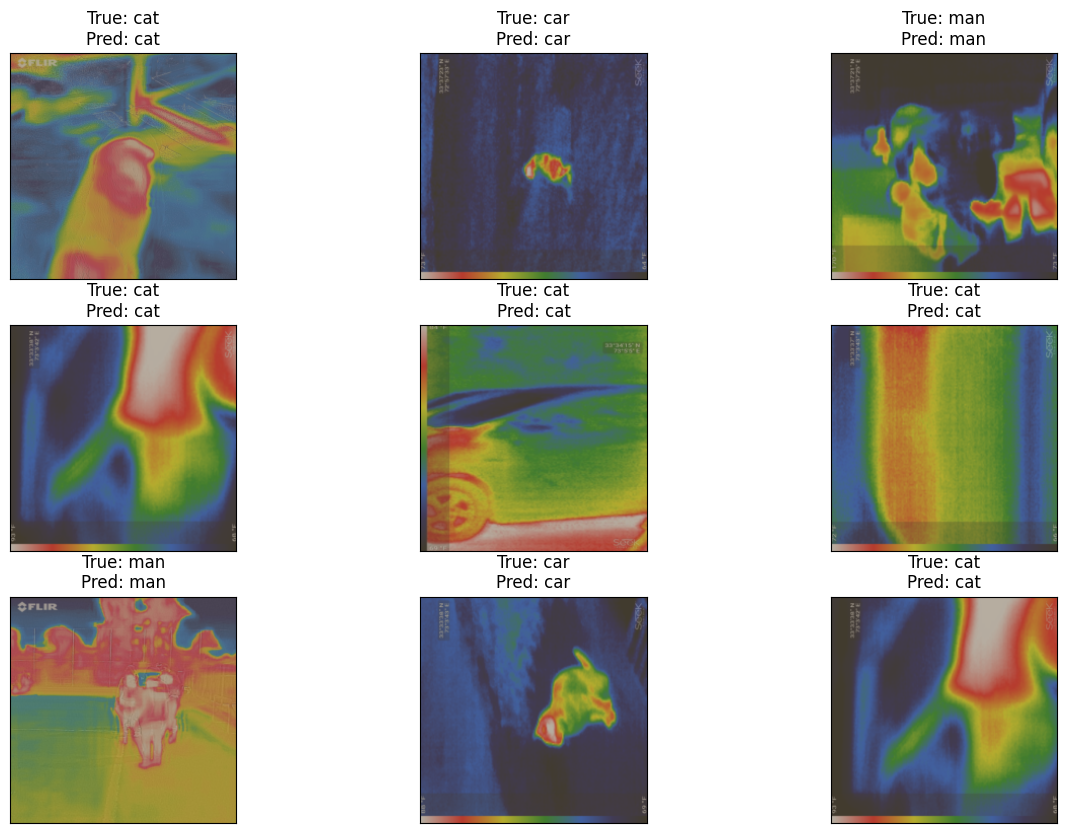

Validating:   0%|          | 0/35 [00:05<?, ?it/s]


In [35]:
def show_images_with_predictions(images, labels, predictions, class_names):
    """
    Displays a batch of images along with the true and predicted labels.

    Parameters:
    - images (torch.Tensor): The images to display.
    - labels (torch.Tensor): The true labels of the images.
    - predictions (torch.Tensor): The predicted labels of the images.
    - class_names (list): List of class names corresponding to the labels.
    """
    images = images.cpu()  # Move images to CPU for displaying
    labels = labels.cpu()  # Move labels to CPU
    predictions = predictions.cpu()  # Move predictions to CPU

    fig = plt.figure(figsize=(15, 10))
    for i in range(min(len(images), 9)):  # Display up to 9 images
        ax = fig.add_subplot(3, 3, i+1, xticks=[], yticks=[])
        img = images[i].permute(1, 2, 0)  # Change dimensions from CxHxW to HxWxC
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
        img = img.numpy()
        plt.imshow(img)
        ax.set_title(f"True: {class_names[labels[i]]}\nPred: {class_names[predictions[i]]}")

    plt.show()

# Validation Phase with Image Display
model.eval()
class_names = combined_dataset.classes  # Get the class names from the dataset

val_loader_tqdm = tqdm(val_loader, desc="Validating")
with torch.no_grad():
    for images, labels in val_loader_tqdm:
        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)

        # Display a batch of images with predictions
        show_images_with_predictions(images, labels, predicted, class_names)

        break  # Remove or modify this line if you want to display more batches


# Key Take Aways:

It is important to be familiar with the structure of the data set In the location the images, masks etc. this is been important as there are various data loaders that can be used, however they often required the data set to be in an expected structure. In this case, it was important to ensure that the images for each class were in its own folder (man, cat, car) and the same for the masks.

Also, it is important to choose a strong model for a given task. Hugging face offers hundreds (perhaps thousands) of available image data sets, however the model used in this example appears to be the most popular for image classification at this time. Although it is possible to search through the various models to perhaps tailor to a specific task, I believe it is best practice to use proven models that are popular and well tested.






# Conclusion

We were able to display the effectiveness of Pytorch with Hugging Face to solve this image classification task. The model was able to achieve an accuracy of .99 on the validation set, and we were able to display the predictions to confirm that the predictions are in fact accurate. It is important to be familiar with How to properly load image data sets using data loaders, and is also important to choose a strong pre-trained model for a given task. It is recommended to experiment models available on the Huggin Face website. Pytorch and TensorFlow also offer great models that can be experimented with.

Thank you to anyone who is taken the time to review this notebook. Please feel free to leave comments, feedback, critiques etc. I would greatly appreciate any feedback that could be helpful and would be glad to respond to any questions anyone may have. I hope that this notebook has been helpful to anyone seeking to learn about image segmentation.




